# NAOC SIMULATION

### Characteristics of the Program:

1. **Modular Structure:** Employing a modular structure, the code organizes multiple classes, including `OnlineSolver`, `Observer`, `CriticNN`, `ActorNN`, `Controller`, and `Sim1`. This design enhances code readability and maintainability.

2. **Object-Oriented Design:** The code adheres to object-oriented programming (OOP) principles by defining classes and their methods. This approach facilitates encapsulation of related functionalities within classes, improving code organization and reusability.

3. **TensorFlow Usage:** TensorFlow is utilized for defining and manipulating tensors, constructing neural networks (e.g., RBFNN), and implementing online solvers.

4. **OnlineSolver:** The `OnlineSolver` class serves as a generic entity for updating states based on a state reducer function, showcasing its applicability in various iterative algorithms.

5. **Observer:** Implemented within the `Observer` class, an observer for a control system includes an observer state reducer, an execution method, and other pertinent functionalities.

6. **CriticNN and ActorNN:** These classes form integral components of an actor-critic architecture, commonly employed in reinforcement learning. They involve the definition of neural networks, learning rates, and other parameters.

7. **Controller:** The `Controller` class represents a controller, equipped with methods for predicting control actions based on state variables.

8. **Simx:** The `Simx` class is designed for simulating a system with a specific state reducer. It encompasses the updating of the state based on a control input, subsequently returning the state and output.

9. **Configuration Parameters:** Parameters such as learning rates, forgetting rates, and other coefficients have been introduced to allow flexibility and customization of the control system.

The code also includes a simulation scenario using the NAOC (Nonlinear Adaptive Observer and Controller) framework. It utilizes various classes and parameters to simulate a control system, providing visualizations of system states, observer estimates, and other relevant metrics over time. The simulation involves iterative steps, updating the control system based on observed states and feedback mechanisms.

In [1]:
%load_ext autoreload
%autoreload 2

### Tensor
A tensor is a mathematical object that generalizes the concept of scalars, vectors, and matrices. In simple terms, a tensor is a multi-dimensional array of numbers. Tensors are used in various fields, including physics, engineering, machine learning, and computer science.


### Tensorflow

TensorFlow is an open-source machine learning framework developed by the Google Brain team. It is widely used for building and training various machine learning and deep learning models. TensorFlow provides a comprehensive set of tools, libraries, and community resources to help researchers and developers create applications for tasks like image and speech recognition, natural language processing, and more.

Key features of TensorFlow include:

1. **Graph-based computation:** TensorFlow uses a computational graph to represent and execute computations. This graph defines the operations and dependencies between them, enabling efficient parallel computation.

2. **Flexibility:** TensorFlow is versatile and supports a range of platforms, devices, and deployment scenarios. It can run on CPUs, GPUs, or TPUs (Tensor Processing Units), and it can be deployed on various devices, including desktops, servers, and mobile devices.

3. **High-level APIs:** TensorFlow provides high-level APIs like Keras, which simplifies the process of building and training deep learning models. Keras is now integrated as the official high-level API in TensorFlow, making it accessible and easy to use.

4. **Scalability:** TensorFlow is designed to scale easily, allowing users to train models on large datasets using distributed computing. This is crucial for handling complex models and large amounts of data.

5. **Community and Ecosystem:** TensorFlow has a large and active community of developers, researchers, and practitioners. This community contributes to the framework's growth and provides a wealth of resources, including documentation, tutorials, and pre-trained models.

In [2]:
import tensorflow as tf

### Numpy 

NumPy (Numerical Python) is a powerful open-source library for numerical computing in Python. It provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays. NumPy is a fundamental package for scientific computing in Python and is used extensively in fields such as machine learning, data science, signal processing, and more.

In [3]:
import numpy as np

### Matplotlib:
   Matplotlib is a popular data visualization library in Python, and `pyplot` provides a MATLAB-like interface for creating plots and charts.

In [4]:
import matplotlib.pyplot as plt

### IPython.display:
   The following line imports the `display` and `clear_output` functions from the `IPython.display` module. These functions are often used in interactive computing environments like IPython or Jupyter Notebooks to control the output display, updating it dynamically.

In [5]:
from IPython.display import display, clear_output
import time

### ActorNN class implementation:

Purpose:
- Implements an Actor Neural Network for control systems. Predicts control actions based on error/surface variable.

Dependencies:
- TensorFlow, OnlineSolver, RBFNN, Observer, CriticNN

Attributes:
- rbfnn_vector: Tuple of RBFNNs used for function approximation
- q: Importance of state error 
- r: Importance of control effort
- kb: Compact set parameter
- learning_rate: Learning rate for weight updates
- criticnn: Instance of CriticNN 
- observer: Instance of Observer
- actordata: Variable to store RBFNN outputs
- actor_solver: OnlineSolver for updating actor weights

Methods:
- __init__: Constructor that initializes attributes
- set_criticnn: Sets criticnn instance  
- predict: Predicts actor output using RBFNN vector
- __call__: Callable predict method
- actor_state_reducer: Computes derivative of actor weights
- update: Updates actor weights using solver, observer terms and critic
$$
\dot{\hat{W}}_{{a}_i} = \frac{q_i}{2r_i (k_{b_i}^2 - s_i^2)} \phi_i s_i - \xi_{a_i} \phi_i \phi_i^T W_{\hat{a}_i} + \frac{\xi_{c_i}}{4r_i (\gamma_i^T \gamma_i + 1)} \phi_i \phi_i^T \hat{W}_{{a}_i} \gamma_i^T \hat{W}_{{c}_i}.
$$

Usage:
- Created with parameter tensors and module instances  
- Output predicted using error variable as input
- Weights updated based on observed data

Key Aspects:
- Leverages RBFNN function approximation
- Learns via reinforcement from critic and observer
- Provides modular component for control systems

In [7]:
from naocnp.actornn import ActorNN

### Observer Class Overview
The Observer class, inheriting from the `tf.Module` class. It employs a constructor with various parameters, including L, C, Bn, learning_rate, forgetting_rate, rbfnn_input_dim_vector, rbfnn_output_dim_vector, rbfnn_num_centers_vector, rbfnn_sigma_vector, rbfnn_input_intervals_vector, x_init, solver_step, and dtype. These parameters initialize system matrices, learning/forgetting rates, RBFNN parameters, initial state, solver step size, and data type.

#### RBFNN Instances
The class features an attribute called `rbfnn_vector`, a list of RBFNN instances for system state estimation. Each instance, generated by the `RBFNN.generator` method, possesses input/output dimensions, centers, sigma value, and input intervals. This aids in estimating the system state using a set of RBFNN instances.

#### Observer Solver
An additional attribute, `observer_solver`, is an instance of the `OnlineSolver` class. This utility facilitates numerical simulations with an online state update mechanism. It requires a state reducer function, solver step size, and an initial state as parameters. The `state_reducer` function computes state derivatives based on system matrices, observed output, control input, and RBFNN output. This function is employed by `observer_solver` to update the internal state at each time step.

$$
\dot{\hat{x}} = A\hat{x} + Ly + \sum_{i=1}^{n} B_i \hat{f}_i(\hat{\bar{x}}_i | \hat{W}_{i,f}) + B_nu
$$
$$
\hat{y} = C\hat{x} \tag{3}
$$

where: 
- $\hat{x} = [\hat{x}_1, \ldots, \hat{x}_n]^T$
- $L = [l_1, \ldots, l_n]^T$ is the observer gain
- $C = [1, 0, \ldots, 0]$
- $B_i = [0, \ldots, 1_i, \ldots, 0]^T$ 
- $B_n = [0, \ldots, 1]^T$. 
- $L$ is chosen such that $A$ is a strict Hurwitz matrix. 

\begin{bmatrix}
-l_1 &  &  &\\ 
\vdots &  & I &\\ 
-l_n & 0 & \ldots & 0 
\end{bmatrix}


Thus, given a positive definite matrix $Q = Q^T > 0$, there exists a positive definite matrix $P = P^T > 0$ satisfying 

\begin{align*}
A^T P + P A = -Q. \tag{4}
\end{align*}


#### Update Law Solver
The Observer class includes another attribute, `updatelaw_solver`, also an instance of the `OnlineSolver` class. This solver updates RBFNN weights using an update law, factoring in the error between observed and estimated outputs, learning/forgetting rates, and an additional term. The `updatelaw_state_reducer` function calculates the state derivative for the update law, updating the external state of RBFNN weights at each time step.
$$
\dot{\hat{W}}_f = \eta_W \phi_f (y - \hat{y})C A^{-1} - \rho_W |y - \hat{y}|\hat{W}_f
$$

#### Execution Method
The `exec` method executes the observer for a given time step, taking observed output and control input as parameters. It returns the updated estimated state and estimated output. This method utilizes `observer_solver` to update the internal state and `update` method to update RBFNN weights using `updatelaw_solver`. The estimated output is computed by multiplying the output matrix and estimated state.

#### Additional Methods
- **Critic Normalizer**: The `critic_normalizer` method computes the critic normalizer for the error surface. It takes observed and estimated outputs as parameters, returning a tensor of critic normalizer values. The method calculates this by combining the RBFNN output with the product of the L matrix and the difference between observed and estimated outputs.
- **Error Surface**: The `error_surface` method computes the error surface, measuring the error between virtual and actual controllers in the control system. It takes a virtual-actual controller tensor as a parameter and returns a tensor of error surface values. The method calculates this by subtracting the virtual-actual controller tensor from the estimated state.
$$ \dot{s}_i(t) = \hat{x}_{i+1} + \hat{W}^T_{i,f}\phi_{i,f}(\hat{\bar{x}}_i) + l_i(y - \hat{y}) - \dot{\hat{\alpha}}_{i-1}. \tag{19}$$

In [8]:
from naocnp.observer import Observer

The Controller class is defined in the controller.py file, and it is designed for generating control inputs based on the error variable in a dynamical system. The Controller class has the following structure and usage:

- **Initialization**: The Controller class takes the following parameters to initialize an instance:
    - actornn: An instance of the ActorNN class, which predicts the control actions based on the error variable and updates the actor weights.
    - eta: A tensor of shape (n, 1) that determines the weight of the barrier function in the cost function.
    - eta_bar: A tensor of shape (n, 1) that is used to penalize the square of the error variable in the cost function, reflecting the control objective of minimizing the tracking error.
    - r: A tensor of shape (n, 1) that represents the importance of the control effort.
    - kb: A tensor of shape (n, 1) that defines a compact set containing the origin.
    - dtype: A TensorFlow data type for tensors. The default is tf.float32.
- **Prediction**: The Controller class has a predict method that takes the error variable (s) as input and returns the control input (alpha) as output. The predict method computes the control input as follows:
$$
\alpha^*_i (t) = - \frac{\eta_i si}{r_i \left( k^2_{bi} - s^2_i \right)} - \frac{\bar{\eta}_i si}{r_i} - \frac{1}{2r_i} \left( \hat{W}^T_{i} \phi_i(si) + \epsilon_i(si) \right)
$$
- **Callable**: The Controller class can also be called as a function, which returns the result of the predict method.
- **Example**: To use the Controller class, one can create an instance with the desired parameters and then call it with the error variable. For example:


```python
controller = Controller(actornn, eta, eta_bar, r, kb, ...)
alpha = controller(s)
```


In [9]:
from naocnp.controller import Controller

### Critic Neural Network (CriticNN) Overview

The Actor-Critic RL aims to find an optimal policy for the agent in an environment using two components: Actor and Critic. Critic: The Critic assesses the value of each action taken by the Actor to determine whether the action will result in a better reward, guiding the Actor for the best course of action to take.

#### Initialization Parameters

Upon instantiation, the CriticNN class requires several parameters to set up its attributes:

- **q, r, kb, learning_rate**: Tensors signifying the importance of state error, control effort, compact set parameter, and the learning rate for weight updates, respectively.

- **observer**: An instance of the Observer class, utilized for state estimation and normalization.

- **rbfnn_num_centers_vector**: A vector specifying the number of centers for the Radial Basis Function Neural Network (RBFNN) employed by the critic.

- **eta, eta_bar**: Tensors representing eta and eta bar values, used to penalize the state variable and barrier function in the cost function.

- **actornn**: An optional instance of the ActorNN class, assisting in predicting control actions based on the error variable.

- **rbfnn_input_intervals_vector, rbfnn_sigma_vector**: Optional parameters allowing specification of input intervals and sigma values for the RBFNN, respectively.

- **dtype, solver_step**: Optional parameters determining the data type for tensors and the solver step size.

#### Prediction Method

The CriticNN class provides a predict method, accepting an error variable as input and delivering critic values as output. Leveraging the RBFNN, the predict method computes RBF activation values (phi) and multiplies them with the critic weights to derive the final critic values. Additionally, the RBF activation values are stored in the phi attribute of the class.

#### Update Functionality

An update method within the CriticNN class dynamically adjusts critic weights based on error variables, controller efforts, and observer terms. Employing an online solver with a state reducer function, it computes the derivative of critic weights concerning the cost function and update law. This method also triggers the update method of the associated observer, ensuring synchronization in weight updates.

$$
\dot{\hat{W}}_{{c}_i} = -\frac{\xi_{c_i}} {\left( \gamma_i^T \gamma_i + 1 \right) }\gamma_i \left[ q_i \log \left( \frac{k_{b_i}^2}{k_{b_i}^2 - s_i^2} \right) - \frac{1}{r_i} \left(  \frac{\eta_i s_i}{k_{b_i}^2 - s_i^2} + \bar{\eta}_i s_i \right)^2 
 + \frac{1}{4r_i} \left( \hat{W}_{{a}_i}^T \phi_i(s_i) \right)^2 + \gamma_i^T \hat{W}_{{c}_i} + [ \frac{2\eta_i s_i}{k_{b_i}^2 - s_i^2} + 2 \bar{\eta}_i s_i] (\hat{W}^T_{i, f} \phi_{i, f}(\hat{\bar{x}}_i) + l_i(y - \hat{y}) - \dot{\hat{\alpha}}_{i-1}) \right].
$$

#### Phi Normalizer
A static method named phi_normalizer is included in the CriticNN class. This method calculates the normalized phi value, incorporating RBFNN output, control effort, and observer terms. The resultant normalized phi value becomes a critical component in the state reducer function, facilitating effective updates to critic weights.

$$ \gamma_1 = \phi_1(s_1)(-\frac{1}{r_1(k^2_{b1} - s^2_1)}\eta_1 s_1 - \frac{1}{r_1}\bar{\eta}_1 s_1 - \frac{1}{2r_1}\hat{W}^T_{a1}\phi_1(s_1) + \hat{W}^T_{1,f}\phi_{1,f}(\hat{x}_1) + l_1(y - \hat{y})). $$


In [10]:
from naocnp.criticnn import CriticNN

### Sim1 Class Overview

`sim1.py` introduces a class named `Sim1`, pivotal in simulating a nonlinear dynamical system with two state variables and one control input. Let's explore the intricacies of this class and its role within the project:

#### Class Attributes

The `Sim1` class exhibits the following attributes, shaping its structure and behavior:

- **`solver_step`**: A float value specifying the solver step for the associated OnlineSolver. The default is set to 1e-3.
- **`sim_solver`**: An instance of OnlineSolver utilizing the `sim_state_reducer` function to dynamically update the state vector.
- **`x`**: A TensorFlow Tensor of shape (nstages, 1), representing the state vector. The default initialization is a zero vector.
- **`x_dot_data`**: A TensorFlow Variable of shape (nstages, 1), serving as a storage container for the state derivative vector.
- **`nstages`**: An integer specifying the number of state variables. The default value is 2.

#### Class Methods

The `Sim1` class encapsulates essential methods to facilitate its functionality:

- **`__init__`**: A constructor method responsible for initializing attributes based on given arguments.
- **`sim_state_reducer`**: A function accepting time, state vector, and control input as arguments, returning the state derivative vector. This function also updates the `x_dot_data` attribute with the computed state derivative vector.
- **`exec`**: A method taking the control input as an argument, leveraging the `sim_solver` to update the state vector. This method returns both the updated state vector and the output, representing the first element of the state vector.
- **`__call__`**: A callable method invoking the `exec` method with provided arguments and returning the result.

#### Usage in the Project

The `Sim1` class serves as a vital component for simulating nonlinear dynamical systems, providing an intuitive interface for executing simulations, updating state vectors, and retrieving simulation outputs. The integration of the `OnlineSolver` ensures efficient and dynamic state updates, contributing to the versatility and effectiveness of the class within the broader project context.


In [11]:
from sim1 import Sim1

In [12]:
L = (1, 150)
C = (1, 0)
Bn = (0, 1)
nstages = 2
solver_step = 1e-2

observer_learning_rate = .1
observer_forgetting_rate = 10
observer_rbfnn_input_dim_vector=[1, 2]
observer_rbfnn_output_dim_vector=1
observer_rbfnn_num_centers_vector=5
observer_rbfnn_sigma_vector=3
observer_rbfnn_input_intervals_vector=[
    [(0, 1)], 
    [(0, 1), (-2, 2)]
    ]
q_state_error = [1, 1]
r_control_effort = [5, 1]
kb_constraint = [0.6, 3]
actor_learning_rate = [10, 2]
critic_learning_rate = [20, 5]
actor_rbfnn_num_centers_vector=9
actor_rbfnn_sigma_vector=2
actor_rbfnn_input_intervals_vector=[
    [(-0.06, 0.06)], 
    [(-0.06, 0.06)]
    ]
critic_rbfnn_num_centers_vector=9
critic_rbfnn_sigma_vector=3
critic_rbfnn_input_intervals_vector=[
    [(-6, 6)], 
    [(-6, 6)]
    ]
eta = [1, 10]
eta_bar = [50, 50]
x_hat_int = [0.01, 0]
x_int = [0.5, 0]


The code encompasses a comprehensive set of parameters and arguments utilized in initializing the Controller instance. These include:

- **L and C**: Matrices defining the system and output characteristics for the observer.
- **Bn**: The control matrix governing the observer's behavior.
- **nstages**: The number of stages configuring the controller's operation.
- **solver_step**: The step size determining the resolution of the online solver.
- **observer_learning_rate and observer_forgetting_rate**: Rates dictating the learning and forgetting mechanisms within the observer's update law.
- **observer_rbfnn_input_dim_vector, observer_rbfnn_output_dim_vector, observer_rbfnn_num_centers_vector, observer_rbfnn_sigma_vector, and observer_rbfnn_input_intervals_vector**: Configurations specifying the input dimensions, output dimensions, number of centers, sigma values, and input intervals for the observer's Radial Basis Function Neural Network (RBFNN).
- **q_state_error and r_control_effort**: Weights assigned to the state error and control effort, crucial components influencing the critic cost function.
- **kb_constraint**: The compact set parameter crucial in defining constraints for both the actor and critic.
- **actor_learning_rate and critic_learning_rate**: Rates steering the weight updates for the actor and critic components.
- **actor_rbfnn_num_centers_vector, actor_rbfnn_sigma_vector, and actor_rbfnn_input_intervals_vector**: Specifications for the actor's RBFNN, including the number of centers, sigma values, and input intervals.
- **critic_rbfnn_num_centers_vector, critic_rbfnn_sigma_vector, and critic_rbfnn_input_intervals_vector**: Parameters determining the configuration of the critic's RBFNN, encompassing the number of centers, sigma values, and input intervals.
- **eta and eta_bar**: Values integral to the controller's cost function, representing eta and eta bar.
- **x_hat_int and x_int**: Initial state estimates for both the observer and the system.

This comprehensive set of parameters ensures the Controller instance is endowed with the necessary specifications and configurations, allowing for versatile and nuanced control and observation within the broader system. Each parameter plays a distinct role in shaping the behavior and learning mechanisms, contributing to the overall efficacy and adaptability of the controller in diverse scenarios.


In [13]:
observer = Observer(
    L=L,
    C=C,
    Bn=Bn,
    learning_rate=observer_learning_rate,
    forgetting_rate=observer_forgetting_rate,
    rbfnn_input_dim_vector=observer_rbfnn_input_dim_vector,
    rbfnn_output_dim_vector=observer_rbfnn_output_dim_vector,
    rbfnn_num_centers_vector=observer_rbfnn_num_centers_vector,
    rbfnn_sigma_vector=observer_rbfnn_sigma_vector,
    rbfnn_input_intervals_vector=observer_rbfnn_input_intervals_vector,
    x_init=x_hat_int,
    solver_step=solver_step,
)

The Observer class implements an observer for estimating the state of a dynamical system using a radial basis function neural network (RBFNN), and its initialized with the parameters defined in the previous code snippet, such as L, C, Bn, learning_rate, forgetting_rate, etc.

In [77]:
observer.A

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[  -1.,    1.],
       [-150.,    0.]], dtype=float32)>

In [78]:
observer.C

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>

In [79]:
observer.L

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[  1.],
       [150.]], dtype=float32)>

In [80]:
observer.Bn

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [1.]], dtype=float32)>

In [ ]:
observer.Bn

In [14]:
observer.rbfnn_vector

ListWrapper([_TupleWrapper((1, <naocnp.rbfnn.RBFNN object at 0x000001CE302F1590>)), _TupleWrapper((2, <naocnp.rbfnn.RBFNN object at 0x000001CE2DBBB490>))])

A list of tuples that contains the input dimension and the RBFNN instance for each stage of the observer. The Observer class uses two RBFNNs, one for each stage.

In [15]:
rbfnn1, rbfnn2 = observer.rbfnn_vector[0][1], observer.rbfnn_vector[1][1]

The RBFNN instances for the first and second stage of the observer, respectively. They are obtained by indexing the observer.rbfnn_vector attribute.

In [16]:
rbfnn1.centers

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.86783767, 0.9605744 , 0.34641027, 0.29187858, 0.09965754]],
      dtype=float32)>

The tf.Tensors that store the center values for the RBFNNs. The shape of the tensors depends on the input dimension and the number of centers for each RBFNN. The center values are randomly initialized in the given input intervals.

In [17]:
rbfnn1.weights

<tf.Variable 'Variable:0' shape=(5, 1) dtype=float32, numpy=
array([[-0.44926068],
       [ 1.1857626 ],
       [-0.48445454],
       [ 1.0215465 ],
       [ 0.7754936 ]], dtype=float32)>

The tf.Variables that store the weight values for the RBFNNs. The shape of the variables depends on the number of centers and the output dimension for each RBFNN. The weight values are randomly initialized with a normal distribution.

In [18]:

rbfnn2.centers

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[ 0.91156757,  0.1904459 ,  0.03467023,  0.9159454 ,  0.04894233],
       [-0.44967222, -0.4033289 , -0.69847775, -0.09888172, -0.8007555 ]],
      dtype=float32)>

In [19]:
rbfnn2.weights

<tf.Variable 'Variable:0' shape=(5, 1) dtype=float32, numpy=
array([[ 0.06471789],
       [-0.2172713 ],
       [-0.13481878],
       [-0.56325126],
       [-0.56014335]], dtype=float32)>

In [20]:
actornn = ActorNN(
    q=q_state_error,
    r=r_control_effort,
    kb=kb_constraint,
    learning_rate=actor_learning_rate,
    observer=observer,
    rbfnn_num_centers_vector=actor_rbfnn_num_centers_vector,
    rbfnn_input_intervals_vector=actor_rbfnn_input_intervals_vector,
    rbfnn_sigma_vector=actor_rbfnn_sigma_vector,
    solver_step=solver_step,
)

The ActorNN instance that is initialized with the parameters defined in the previous code snippet, such as q, r, kb, learning_rate, observer, etc.

In [21]:
actornn.rbfnn_vector

(<naocnp.rbfnn.RBFNN at 0x1ce30759f50>, <naocnp.rbfnn.RBFNN at 0x1ce3024ce10>)

A list of tuples that contains the input dimension and the RBFNN instance for each stage of the actor network. The actornn class uses two RBFNNs, one for each stage.

In [22]:
actor_rbfnn1, actor_rbfnn2 = actornn.rbfnn_vector

The RBFNN instances for the first and second stage of the actor network, respectively. They are obtained by indexing the `actornn.rbfnn_vector` attribute.

In [23]:
actor_rbfnn1.weights

<tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.3925766 ],
       [-1.9491045 ],
       [ 0.52433974],
       [-1.5887804 ],
       [-0.7248259 ],
       [ 0.5291847 ],
       [-1.2198642 ],
       [ 1.4161787 ],
       [ 0.72384715]], dtype=float32)>

In [24]:
actor_rbfnn2.weights

<tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.14002271],
       [-0.9250729 ],
       [-0.20905721],
       [ 0.21079732],
       [-1.3265302 ],
       [ 2.2124238 ],
       [-0.38382554],
       [-0.7570272 ],
       [-0.8929947 ]], dtype=float32)>

The tf.Variables that store the weight values for the RBFNNs. The shape of the variables depends on the number of centers and the output dimension for each RBFNN. The weight values are randomly initialized with a normal distribution.

In [25]:
actor_rbfnn1.centers

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[-0.00099189,  0.04461153,  0.04639133,  0.00058093, -0.04307436,
        -0.05543401,  0.03541171,  0.02871538,  0.03384366]],
      dtype=float32)>

In [26]:
actor_rbfnn2.centers

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[ 0.02129109, -0.04257387,  0.00433647, -0.00671355, -0.03657234,
         0.01136417, -0.003622  , -0.00590617,  0.0387393 ]],
      dtype=float32)>

The tf.Tensors that store the center values for the RBFNNs. The shape of the tensors depends on the input dimension and the number of centers for each RBFNN. The center values are randomly initialized in the given input intervals as [(-0.06, 0.06)].

In [27]:
criticnn = CriticNN(
    q=q_state_error,
    r=r_control_effort,
    kb=kb_constraint,
    learning_rate=critic_learning_rate,
    eta=eta,
    eta_bar=eta_bar,
    rbfnn_num_centers_vector=critic_rbfnn_num_centers_vector,
    rbfnn_input_intervals_vector=critic_rbfnn_input_intervals_vector,
    rbfnn_sigma_vector=critic_rbfnn_sigma_vector,
    observer=observer,
    actornn=actornn,
    solver_step=solver_step,
)
actornn.set_criticnn(criticnn)

In [28]:
critic_rbfnn1, critic_rbfnn2 = criticnn.rbfnn_vector

In [29]:
critic_rbfnn1.weights

<tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
array([[ 2.4531245 ],
       [ 1.2998693 ],
       [-0.1600359 ],
       [-0.88807243],
       [-0.6219382 ],
       [-0.29283053],
       [ 0.7289079 ],
       [ 0.6138994 ],
       [-0.42367724]], dtype=float32)>

In [30]:
critic_rbfnn2.weights

<tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.65668607],
       [-1.1512316 ],
       [ 0.635855  ],
       [ 0.63106567],
       [ 0.67511684],
       [-0.61648536],
       [ 0.49061227],
       [ 0.08588847],
       [-0.9236881 ]], dtype=float32)>

In [31]:
critic_rbfnn1.centers

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[-2.382298  , -5.070372  , -2.6034951 , -5.4075565 , -2.6614308 ,
        -5.5712914 ,  5.387083  , -0.53499126, -2.702136  ]],
      dtype=float32)>

In [32]:
critic_rbfnn2.centers

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[-5.4971766e+00,  3.4764204e+00, -1.4205136e+00,  1.0405512e+00,
        -3.2887459e-03, -4.6372204e+00, -2.6305046e+00, -5.8539534e-01,
         2.7281828e+00]], dtype=float32)>

In [33]:
controller = Controller(
    actornn=actornn,
    eta=eta,
    eta_bar=eta_bar,
    r=r_control_effort,
    kb=kb_constraint,
)

The following program is designed to perform simulation tasks using the Sim1 class. Upon instantiation of an instance of the Sim1 class with specified parameters, it is assigned to the variable `simulator`.

Initialization includes setting up arrays to store simulation data, such as state variables, output, and the time array. The initial control input is established at 1.0.

The program iterates over a specified number of steps, executing the subsequent tasks:

- The `exec` method of the simulator is invoked with the control input as an argument. This action results in obtaining the state vector and output. The `exec` method updates the state vector using the online solver and the state reducer function. It then returns the updated state vector and the first element of the state vector as the output.

- Simulation data is stored in the designated arrays by concatenating the state vector and the output.

- The control input undergoes an update using a sinusoidal function with a frequency of 2 Hz and an amplitude of 100. Additionally, the control input is incremented by 1.0 to prevent negative values.

Finally, utilizing matplotlib, the simulation data is plotted, showcasing state variables and output as functions of time. The plot is enhanced with labels, legends, and a title. The resulting plot is displayed using the `show` method.

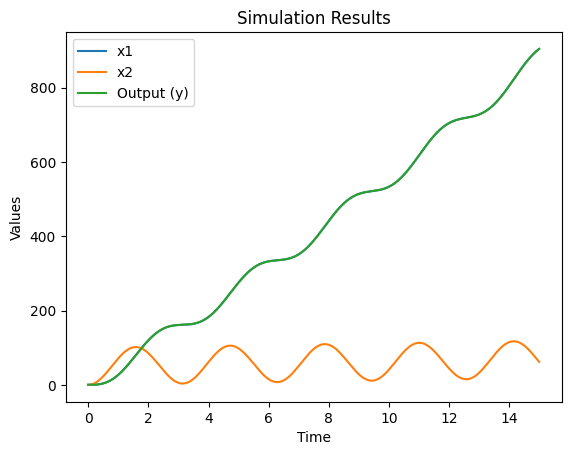

In [34]:
# Define simulation parameters
sim1_duration = 15.0           # Duration of the simulation
sim1_initial_state = [0.1, 0.2]  # Initial state (x1, x2)

system2 = Sim1(x_int=x_int, solver_step=solver_step)
# Simulate the system
num_steps_sim1 = int(sim1_duration / solver_step)
sim1_simulation_data = np.zeros((num_steps_sim1, nstages + 1))  # +1 for sim1_output (y)
control_input_sim1 = 1.0  # Initial control input

for step in range(num_steps_sim1):
    sim1_state, sim1_output = system2.exec(control_input_sim1)
    sim1_simulation_data[step, :] = np.concatenate([sim1_state.numpy().flatten(), [sim1_output]])

    # Update the control input (you may change this logic based on your scenario)
    control_input_sim1 = 100 * np.sin(2 * step * solver_step) *  + 1.0

# Plot the results
sim1_time_array = np.arange(0, sim1_duration, solver_step)
plt.plot(sim1_time_array, sim1_simulation_data[:, 0], label='x1')
plt.plot(sim1_time_array, sim1_simulation_data[:, 1], label='x2')
plt.plot(sim1_time_array, sim1_simulation_data[:, 2], label='Output (y)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Simulation Results')
plt.show()


## Adding observer

The following Python script utilizes the Sim1 and Observer classes to simulate and estimate a nonlinear dynamical system with a sinusoidal control input. It also employs matplotlib for plotting simulation and estimation data. The script is organized as follows:

### Parameters:
- The script defines various parameters for the simulation and observer, including duration, number of steps, batch size, observer gain, and RBFNN number of centers.

### Create Sim1 and Observer Instances:
- An instance of the Sim1 class is created with specified parameters and assigned to the variable `system3`. Sim1 simulates the nonlinear dynamical system using an online solver and a state reducer function. 
- An instance of the Observer class is created with given parameters and assigned to the variable `observer2`. The Observer class estimates the system state using an online solver and RBFNNs.

### Arrays:
- Arrays are initialized to store simulation and estimation data, such as state variables, state estimates, and the time array. Additionally, an array for the control input is created, representing a sinusoidal function.

### Figure and Axis:
- Figure and axis objects are set up for plotting simulation and estimation data using matplotlib. Labels and legends are defined for the axes. A separate figure and axis are created for each variable plotted (e.g., x1, x2, x1_hat, x2_hat).

### Main Simulation Loop:
- The script iterates over the specified number of steps, performing the following tasks:
    - Execute simulation and estimation steps: The system and observer are executed with control input and system output as arguments. State vector and output are obtained from the system, while state estimate and output estimate are obtained from the observer.
    - Store simulation and estimation data: Data is stored in corresponding arrays, with state variables and estimates extracted from tensors returned by the system and observer.
    - Plot: Matplotlib is used to plot simulation and estimation data. Axes are cleared, and data for each variable are plotted as functions of time. Figures are displayed and updated periodically based on the batch size.


The script demonstrates the usage of the Observer class to estimate the state of the nonlinear dynamical system simulated by the Sim1 class. It also showcases how to plot simulation and estimation data using matplotlib. The expected outcome is that the observer converges to the real system states, with estimation curves closely following simulation curves and small, bounded estimation errors.

Observer gain and RBFNN center initialization parameters impact observer performance. Observer gain influences the feedback gain matrix, while RBFNN parameters (number of centers, sigma values, and input intervals) affect the accuracy and complexity of the RBFNN approximation.

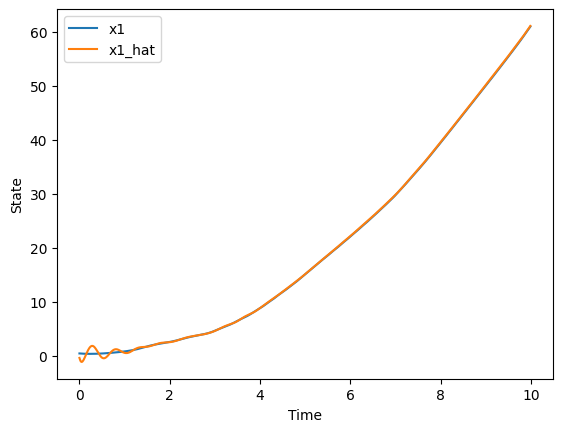

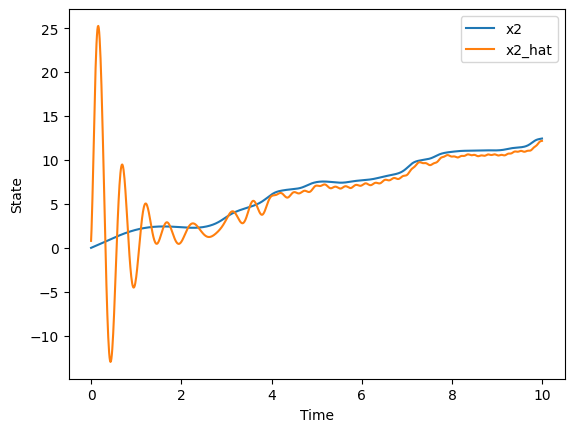

In [75]:
# Parameters
sim_duration = 10  # Duration of simulation
num_steps = int(sim_duration / solver_step)
batch_size = 100
L1 = [5, 150]
observer_rbfnn_num_centers_vector1 = 1024

# Create Sim1 instance
system3 = Sim1(x_int=x_int, solver_step=solver_step)
observer2 = Observer(
    L=L1,
    C=C,
    Bn=Bn,
    learning_rate=observer_learning_rate,
    forgetting_rate=observer_forgetting_rate,
    rbfnn_input_dim_vector=observer_rbfnn_input_dim_vector,
    rbfnn_output_dim_vector=observer_rbfnn_output_dim_vector,
    rbfnn_num_centers_vector=observer_rbfnn_num_centers_vector1,
    rbfnn_sigma_vector=observer_rbfnn_sigma_vector,
    rbfnn_input_intervals_vector=observer_rbfnn_input_intervals_vector,
    x_init=x_hat_int,
    solver_step=solver_step,
)


# Arrays to store simulation data
time = np.arange(0, sim_duration, solver_step)
u_data = np.sin(2 * time)  # Example input signal
datasize = max(time.shape)
x1_data = np.zeros(datasize)
x2_data = np.zeros(datasize)
x1_hat_data = np.zeros(datasize)
x2_hat_data = np.zeros(datasize)

# Create figure and axis for plotting
figx1, ax1 = plt.subplots()
figx2, ax2 = plt.subplots()

j = 0
i_base = 0
# Main simulation loop
for i in range(num_steps):
    # Execute simulation step
    x, y = system3.exec(u_data[i])
    x_hat, y_hat = observer2(y, u_data[i])
    

    # Store simulation data
    x1, x2 = x.numpy().flatten()
    x1_hat, x2_hat = x_hat.numpy().flatten()
    
    x1_data[j] = x1
    x2_data[j] = x2
    x1_hat_data[j] = x1_hat
    x2_hat_data[j] = x2_hat
    j += 1
    if not (j % batch_size):
        # Plot
        ax1.clear()
        ax1.plot(time[:j], x1_data[:j], label='x1')
        ax1.plot(time[:j], x1_hat_data[:j], label='x1_hat')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('State')
        ax1.legend()
        
        ax2.clear()
        ax2.plot(time[:j], x2_data[:j], label='x2')
        ax2.plot(time[:j], x2_hat_data[:j], label='x2_hat')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('State')
        ax2.legend()

        clear_output(wait=True)
        display(figx1)
        display(figx2)
        plt.pause(0.001)  # Pause to update the plot

plt.close()


#### Parameters Definition:

The code initializes crucial parameters dictating the simulation's behavior. These include the simulation duration, the number of steps, the batch size determining data plotting frequency, and the initial value of the error surface. These parameters collectively govern the simulation's temporal dynamics, execution frequency, plotting intervals, and initial controller input

#### Arrays Initialization: 

The code creates arrays to store simulation data, encompassing state variables, state estimates, RBFNN weights, control inputs, and alpha values. These arrays, initialized with zeros, align in shape with the simulation time array generated using numpy.arange. Each array plays a distinct role in encapsulating the evolving state of the system.

In [36]:
# Parameters
sim_duration = 10  # Duration of simulation
num_steps = int(sim_duration / solver_step)
batch_size = 100
s = None

In [37]:
# Arrays to store simulation data
simulation_time = np.arange(0, sim_duration, solver_step)
shape = simulation_time.shape
x1_data = np.zeros(shape=shape)
x2_data = np.zeros(shape=shape)
x1_hat_data = np.zeros(shape=shape)
x2_hat_data = np.zeros(shape=shape)
w1f_data = np.zeros(shape=shape)
w2f_data = np.zeros(shape=shape)
w1a_data = np.zeros(shape=shape)
w2a_data = np.zeros(shape=shape)
w1c_data = np.zeros(shape=shape)
w2c_data = np.zeros(shape=shape)
alpha1_data = np.zeros(shape=shape)
u_data = np.zeros(shape=shape)


#### Figure and Axis Creation: 

Matplotlib is employed to generate figure and axis objects, each dedicated to plotting specific simulation variables such as x1, x2, w1f, w2f, etc. Axes labels are appropriately set, and lists of axes and figures are created for organizational convenience.

#### Main Simulation Loop

Within the main loop, the code iterates over the specified number of steps, executing the following tasks:

- **Simulation Step Execution**: The `controller` function is invoked with the error surface as an argument, yielding the control vector. This vector, containing the alpha value and the control input, drives the execution of the system and observer instances. The error surface is concurrently updated using the observer method, encapsulating the evolving error variable and its derivative for the controller.

- **RBFNN Update**: The code dynamically adjusts the weights of the RBFNNs for both the critic and actor. Instances of CriticNN and ActorNN classes, responsible for adaptive critic design, receive the error surface, control vector, system output, and state estimate as input arguments. Utilizing the gradient descent algorithm, the RBFNNs adapt their weights based on the cost function and learning rate.

- **Data Storage**: Simulation data, including state variables, state estimates, RBFNN weights' norms, alpha value, and control input, is systematically stored in the designated arrays. A counter variable `j` facilitates indexing, incrementing after each step.

- **Plotting**: The code visually represents the evolving simulation data using matplotlib. Axes are cleared, and data for each variable is plotted with corresponding labels. Legends enhance interpretability. The code repeats this plotting process at intervals defined by the batch size, regulated by a conditional statement checking the remainder of `j` divided by the batch size. The base index `i_base` is updated accordingly.

In [38]:
system = Sim1(x_int=x_int, solver_step=solver_step)

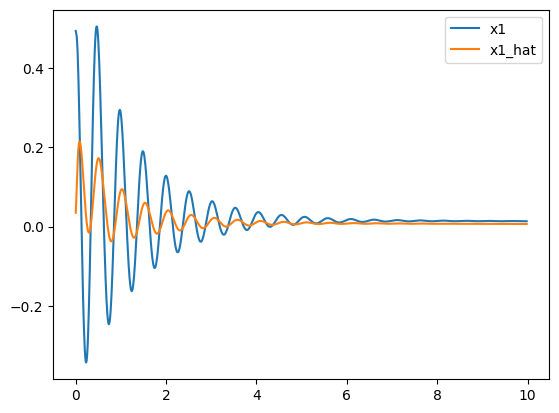

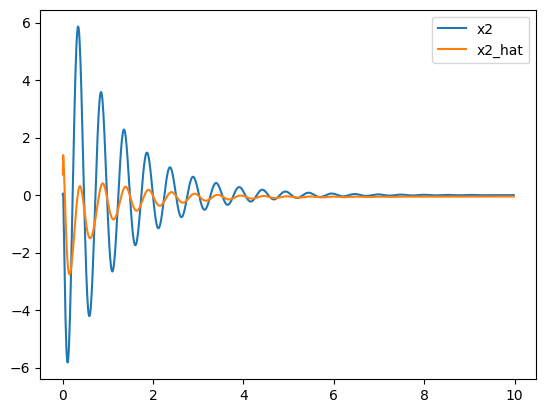

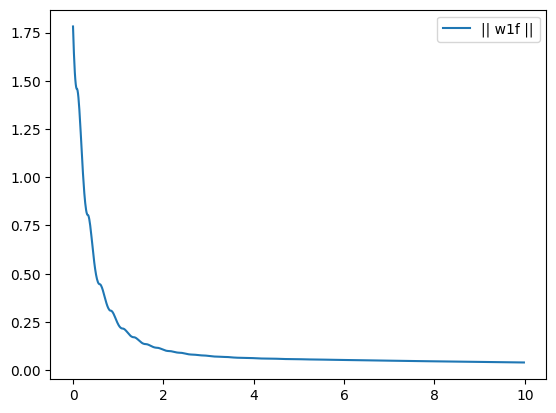

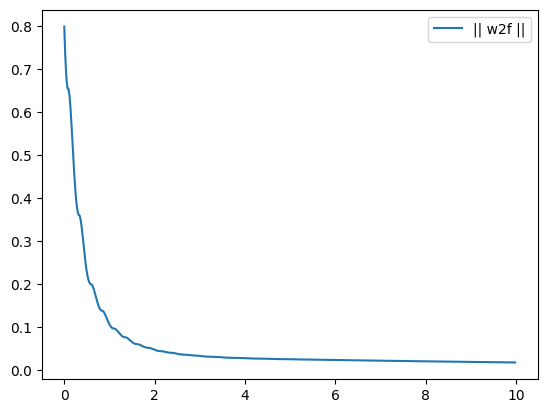

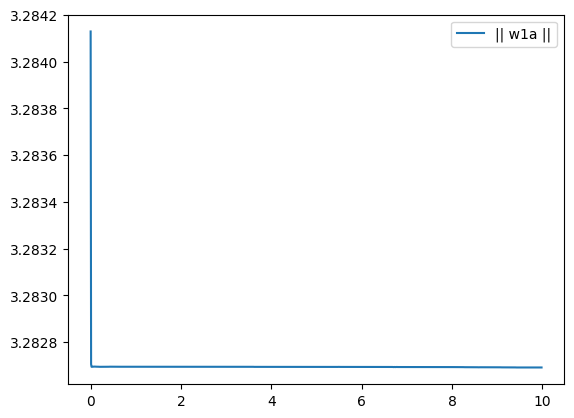

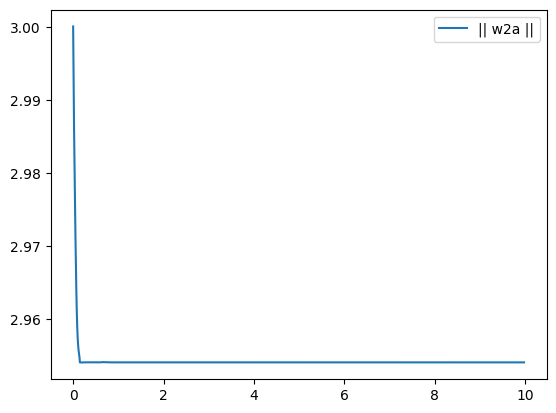

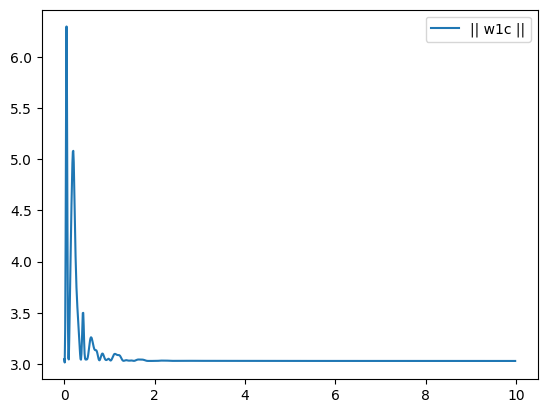

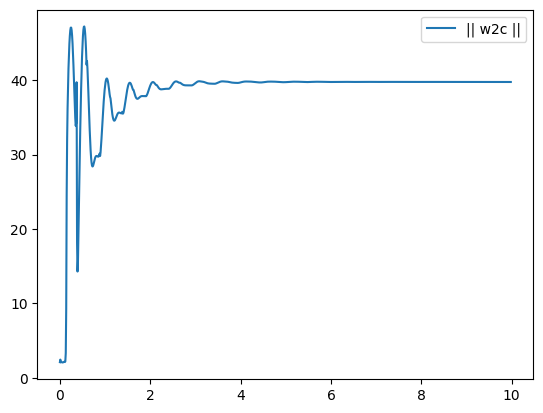

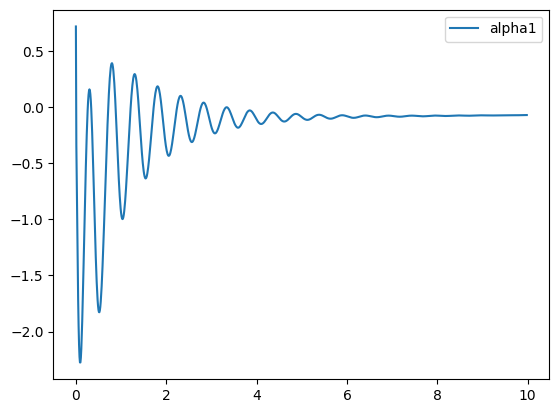

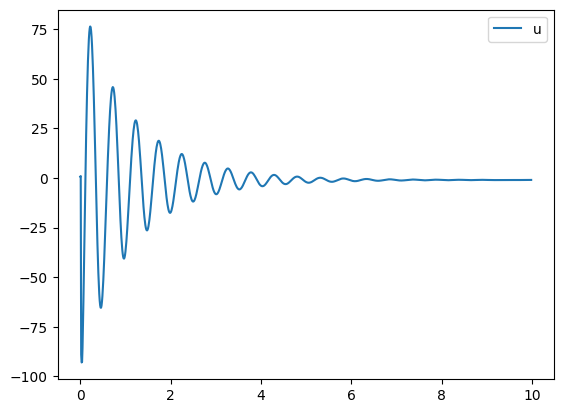

In [39]:
#  figure and axis for plotting
figx1, ax1 = plt.subplots()
figx2, ax2 = plt.subplots()
figw1f, aw1f = plt.subplots()
figw2f, axw2f = plt.subplots()
figw1a, axw1a = plt.subplots()
figw2a, axw2a = plt.subplots()
figw1c, axw1c = plt.subplots()
figw2c, axw2c = plt.subplots()
figwalp1, axalp1 = plt.subplots()
figu, axu = plt.subplots()

ax_list = [ax1, ax2, aw1f, axw2f, axw1a, axw2a, axw1c, axw2c, axalp1, axu]
fig_list = [figx1,figx2,figw1f,figw2f,figw1a,figw2a,figw1c,figw2c,figwalp1,figu]
[(ax.set_xlabel('Time'), ax.set_ylabel('State')) for ax in ax_list]

j = 0
i_base = 0
# Main simulation loop
for i in range(num_steps):
    # t0 = time.time()
    # simulation step execution
    control_vct = controller(s)
    x, y = system.exec(control_vct[-1, 0])
    x_hat, y_hat = observer(y, control_vct[-1, 0])
    s = observer.error_surface(control_vct)

    criticnn.update(s, control_vct, y, y_hat)
    actornn.update(s, control_vct, y, y_hat)
    # t1 = time.time()
    
    # Store simulation data
    x1, x2 = x.numpy().flatten()
    x1_hat, x2_hat = x_hat.numpy().flatten()
    
    w1f, w2f = observer.rbfnn_vector[0].weights, observer.rbfnn_vector[1].weights
    w1a, w2a = actornn.rbfnn_vector[0].weights, actornn.rbfnn_vector[1].weights
    w1c, w2c = criticnn.rbfnn_vector[0].weights, criticnn.rbfnn_vector[1].weights
    
    w1f, w2f = tf.norm(w1f), tf.norm(w2f)
    w1a, w2a = tf.norm(w1a), tf.norm(w2a)
    w1c, w2c = tf.norm(w1c), tf.norm(w2c)
    alpa1, u = control_vct[0, 0], control_vct[1, 0]
    # print(f"w1f: {w1f}, w2f: {w2f}")
    # print(f"w1a: {w1a}, w2a: {w2a}")
    # print(f"w1c: {w1c}, w2c: {w2c}")
    

    x1_data[j] = x1
    x2_data[j] = x2
    x1_hat_data[j] = x1_hat
    x2_hat_data[j] = x2_hat
    w1f_data[j] = w1f
    w2f_data[j] = w2f
    w1a_data[j] = w1a
    w2a_data[j] = w2a
    w1c_data[j] = w1c
    w2c_data[j] = w2c
    alpha1_data[j] = alpa1
    u_data[j] = u
    j += 1

    if not (j % batch_size):
        # Plot
        [(ax.clear()) for ax in ax_list]
        ax1.plot(simulation_time[:i], x1_data[:i], label='x1')
        ax1.plot(simulation_time[:i], x1_hat_data[:i], label='x1_hat')
        ax2.plot(simulation_time[:i], x2_data[:i], label='x2')
        ax2.plot(simulation_time[:i], x2_hat_data[:i], label='x2_hat')
        aw1f.plot(simulation_time[:i], w1f_data[:i], label='|| w1f ||')
        axw2f.plot(simulation_time[:i], w2f_data[:i], label='|| w2f ||')
        axw1a.plot(simulation_time[:i], w1a_data[:i], label='|| w1a ||')
        axw2a.plot(simulation_time[:i], w2a_data[:i], label='|| w2a ||')
        axw1c.plot(simulation_time[:i], w1c_data[:i], label='|| w1c ||')        
        axw2c.plot(simulation_time[:i], w2c_data[:i], label='|| w2c ||')
        axalp1.plot(simulation_time[:i], alpha1_data[:i], label='alpha1')        
        axu.plot(simulation_time[:i], u_data[:i], label='u')
        [(ax.legend()) for ax in ax_list]

        clear_output(wait=True)
        [display(fig) for fig in fig_list]
        plt.pause(0.001)  # Pause to update the plot
        i_base = i + 1

#### Closing and Finalization

- **Figure Closure**: Post-simulation loop completion, the code ensures proper closure of figures, streamlining memory usage and finalizing the visualization process.

This meticulously orchestrated simulation code seamlessly integrates the Controller, System, and Observer classes to model and evaluate the dynamics of a control system. Its modular design, parameter configuration, and visualization strategies collectively contribute to an efficient and insightful simulation framework.

In [40]:
plt.close()